# Rigorous Thermodynamic Decomposition of Salt Effects on the Polymerization of Polyethylene Glycol

Stefan Hervø-Hansen<sup>a,</sup>, Jan Heyda<sup>b,</sup>, and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague CZ-16628, Czech Republic.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp, heydaj@vscht.cz, and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 3: Analysis

### Introduction
Here we aim to provide a detailed thermodynamic analysis of how NaCl influence the solvation of polyethylene glycol (PEG). By utilizing molecular dynamics simulations, we can gain atomic insight into the mechanism which underpins the change in excess chemical potential of PEG with the addition of NaCl. Understanding these effects is crucial for applications in biochemistry and materials science, where PEG and its derivatives are widely used. The following sections detail the methods and materials employed in our simulations and analyses.

### Methods & Materials
Molecular dynamics simulations were conducted using the OpenMM (8.0)[<sup>1</sup>](#fn1) software package. The details of these simulations can be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG, a CHARMM-derived force field (C35r) was utilized, which has previously been shown to reproduce the hydrodynamic radii and shape anisotropy of PEG[<sup>2</sup>](#fn2). The PEG force field was combined with the SPC/E force field for water[<sup>3</sup>](#fn3) and optimized ion parameters for sodium chloride[<sup>4</sup>](#fn4).

The isothermal-isobaric ensemble was sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6) and a Monte Carlo barostat[<sup>7,</sup>](#fn7)[<sup>8</sup>](#fn8). The trajectories were analyzed using MDTraj[<sup>9</sup>](#fn9) for structural properties, while ERmod[<sup>10</sup>](#fn10) was used for the calculation of solvation free energies. The calculation of solvation free energy can be found in the [Part 2 Jupyter notebook](ERmod.ipynb) and the analysis of data can be found in [Part 3 Jupyter notebook](Analysis.ipynb)

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 8: Molecular Dynamics Simulation with Machine Learning Potentials. J. Phys. Chem. B 128, 109–116 (2023). </span><br>
2. <span id="fn2"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
3. <span id="fn3"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
4. <span id="fn4"> J. Heyda, J. C. Vincent, D. J. Tobias, J. Dzubiella, P. Jungwirth, Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations of N-Methylacetamide in Aqueous Salt Solutions. J. Phys. Chem. B 114, 1213–1220 (2009). </span><br>
5. <span id="fn5"> B. Leimkuhler, C. Matthews, Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proc. R. Soc. A. 472, 20160138 (2016). </span><br>
6. <span id="fn6"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
7. <span id="fn7"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
8. <span id="fn8"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
9. <span id="fn9"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015). </span><br>
10. <span id="fn10"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>

## Import of Python Modules & Auxiliary Functions

In [128]:
#Notebook dependent libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import re
import scipy.optimize as optimize
import scipy.ndimage as ndimage
from uncertainties import unumpy
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

from Auxiliary import fessa
plt.set_cmap('fessa')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"]) 

# Physical constants & useful conversions
kcal_to_kT = 1.688 # Assuming 298.15 K
Na = 6.02214076e23 # Avogadro constant [mol]
liter_to_cubeangstrom = 1e27
nm3_to_l = 1e-24


homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/group1/z44785r/PEO-Solubility


<Figure size 640x480 with 0 Axes>

In [114]:
def get_2D_PMF(xall, yall, weights=None, nbins=50, avoid_zero_count=True, minener_zero=True, kT=1.0, ranges=None):
    """Free energy plot given 2D scattered data.
Builds a 2D-histogram of the given data points and plots -log(p) where p is
the probability computed from the histogram count.
Parameters
----------
xall : ndarray(T)
    sample x-coordinates
yall : ndarray(T)
    sample y-coordinates
weights : ndarray(T), default = None
    sample weights. By default all samples have the same weight
nbins : int, default=100
    number of histogram bins used in each dimension
avoid_zero_count : bool, default=True
    avoid zero counts by lifting all histogram elements to the minimum value
    before computing the free energy. If False, zero histogram counts will
    yield NaNs in the free energy which and thus regions that are not plotted.
minener_zero : bool, default=True
    Shifts the energy minimum to zero. If false, will not shift at all.
kT : float, default=1.0
    The value of kT in the desired energy unit. By default, will compute
    energies in kT (setting 1.0). If you want to measure the energy in
    kJ/mol at 298 K, use kT=2.479 and change the cbar_label accordingly.
ranges : tuple
    The extend the 2d histogram should be compute. The tuple should 
    have the form ((xmin, xmax), (ymin, ymax)).
Returns
-------
(x,y,F)
"""
    # histogram
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights, range=ranges)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT * np.log(z)
    if minener_zero:
        F -= np.min(F)

    return (x,y,F.T)

### Simulation settings

In [115]:
states = { # State of simulations, (outFreq is steps per frame)
          'conf':{'Nsteps': 500000000, 'OutFreq': 1000}, # 1000 nanoseconds, 500.000 frames
          'sol': {'Nsteps': 125000000, 'OutFreq':  500}, #  250 nanoseconds, 250.000 frames
          'ref': {'Nsteps':  50000000, 'OutFreq':  500}, #  100 nanoseconds, 100.000 frames
         }

nmers = [36] # PEG polymer length
Nparticles = {       # Number of PEG and water molecules. Salt is calculated based on concentration input
    'PEG': 1,
    'Water': 10000,
}
NConfs = 100

# Approximate concentrations of salt (in Molar) under which the structual sampling is conducted.
salt_reference_concentrations = { # P1 and P2 are the perturbations that will be added to the salt concentration
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

salts = { # Types of salt added to the simulations.
         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl' }
}
Tbl_concentrations = {
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

GENERATE_ERMOD = True # Conduct ERmod analysis

## Structural Analysis
### Loading the trajectories

In [116]:
%cd -q $homedir
trajs = []

for conc in [0.0, 2.0, 4.0]:
    c = '{0:.2f}'.format(conc)
    traj = md.load_xtc('Simulations/PEG36mer/NaCl/{c}/Solute/trajectory_dry.xtc'.format(c=c),
                       top='Simulations/PEG36mer/NaCl/{c}/Solute/PEG_36_NaCl_{c}.pdb'.format(c=c))
    trajs.append(traj)

/home/z44785r/miniconda3/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


### Polymer relevant properties: radius of gyration, end-to-end distance, and solvent accessible surface area

NaCl	<Rg> (nm)		<End-to-end distance> (nm)	<SASA> (nm²)
0 M	1.2355314517820482	2.6414547			27.688349
2 M	1.0609704809299654	2.2999148			24.27089
4 M	0.9602997513385614	2.076825			22.126816


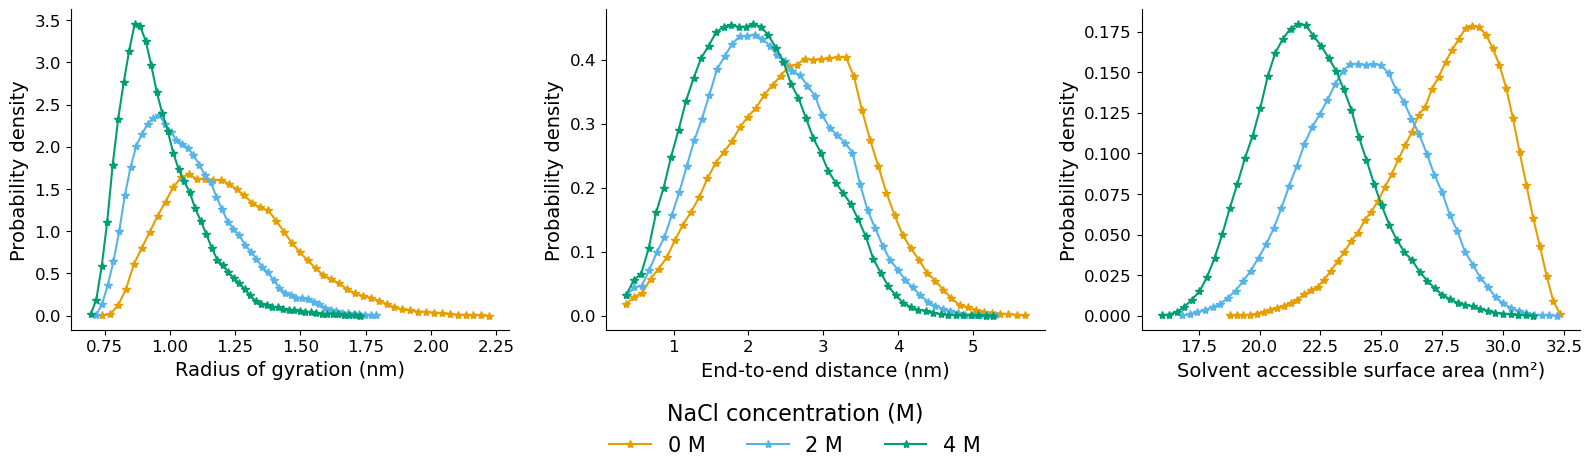

In [117]:
%cd -q $homedir
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

# If data is pre-computed use them, otherwise generate and save the data onto desk.
USE_PRECOMPUTED_DATA = True

labels = ['0 M', '2 M', '4 M']

print('NaCl\t<Rg> (nm)\t\t<End-to-end distance> (nm)\t<SASA> (nm²)')
for i, traj in enumerate(trajs):
    PEG_atoms = traj.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
    traj_PEG = traj.atom_slice(PEG_atoms)
    
    # ANALYSIS #
    # Radius of gyration
    if USE_PRECOMPUTED_DATA:
        rg = np.load('{}/Data/Rg_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:    
        rg = md.compute_rg(traj_PEG)
        np.save('{}/Data/Rg_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), rg)
    y,edges = np.histogram(rg, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[0].plot(centers,y,'-*', label=labels[i])
   
    # End-to-end distance
    if USE_PRECOMPUTED_DATA:
        end_to_end_distances = np.load('{}/Data/end-to-end_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:
        pairs = traj.topology.select_pairs('(resname PGH) and (name C1)', '(resname PGT) and (name C3)')
        end_to_end_distances = md.compute_distances(traj, pairs)
        np.save('{}/Data/end-to-end_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), end_to_end_distances)
    y,edges = np.histogram(end_to_end_distances, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[1].plot(centers,y,'-*', label=labels[i])
    
    # Solvent accessible surface area (SASA)
    if USE_PRECOMPUTED_DATA:
        SASAs = np.load('{}/Data/SASA_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:
        SASAs = md.shrake_rupley(traj_PEG, mode='residue').sum(axis=1)
        np.save('{}/Data/SASA_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), SASAs)
    y,edges = np.histogram(SASAs, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[2].plot(centers,y,'-*', label=labels[i])
    
    # Print mean values
    print(labels[i]+'\t'+str(rg.mean())+'\t'+str(end_to_end_distances.mean())+'\t\t\t'+str(SASAs.mean()))

xlabels = ['Radius of gyration (nm)', 'End-to-end distance (nm)', 'Solvent accessible surface area (nm²)']
for i, ax in enumerate(axes):
    ax.set_ylabel('Probability density', fontsize=14)
    ax.set_xlabel(xlabels[i], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(i, []) for i in zip(*lines_labels)]
    
fig.legend(lines[0:3], labels[0:3], loc = 'lower center', ncol=8, fontsize=15, title='NaCl concentration (M)',
           title_fontsize=16, bbox_to_anchor=(0.5, -0.2), frameon=False)

fig.tight_layout()
fig.savefig('Figures/polymer_properties.pdf', bbox_inches='tight')

### Projection of the conformational space by principle component analysis (PCA) 

Explained variance across whole dataset by PC1: 45%
Explained variance across whole dataset by PC2: 7%

Area of sampled space (0 M): 1245

Area of sampled space (2 M): 983

Area of sampled space (4 M): 746


/tmp/ipykernel_18495/2438858116.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


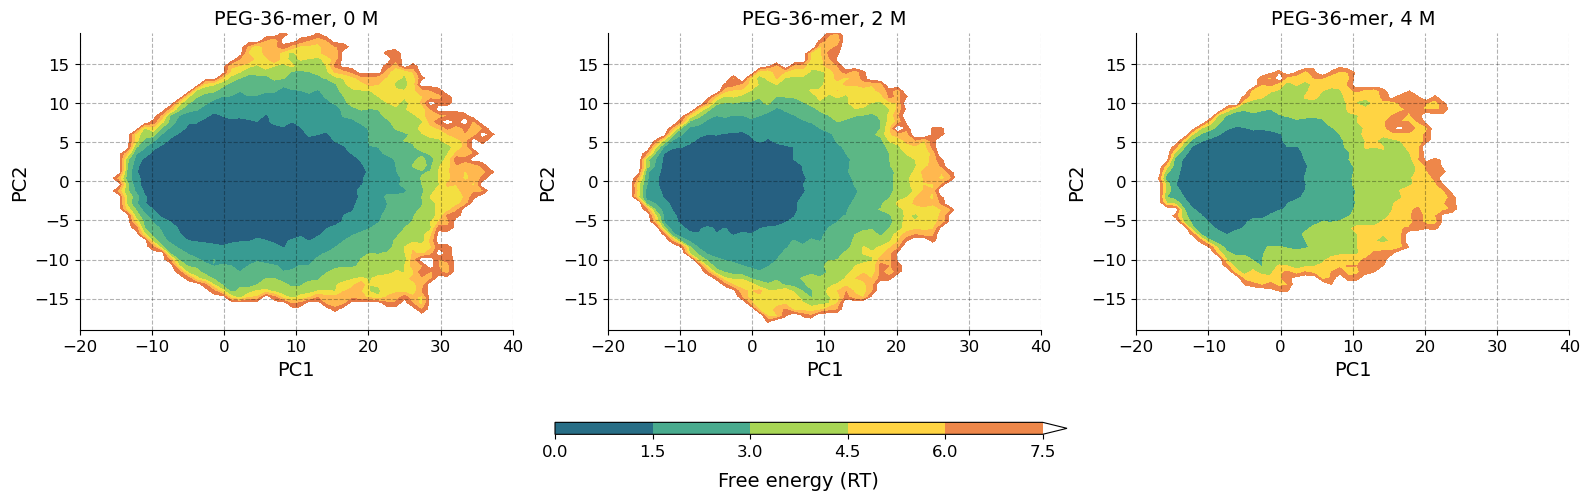

In [118]:
%cd -q $homedir
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

show_confs = False

pca = PCA()

trajs_PEG = []
for i, traj in enumerate(trajs):
    PEG_atoms = traj.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
    traj_PEG = traj.atom_slice(PEG_atoms)
    trajs_PEG.append(traj_PEG)

atom_pairs = trajs_PEG[0].topology.select_pairs('all and element O', 'all and element O')

pairwise_distances = md.compute_distances(trajs_PEG[0]+trajs_PEG[1]+trajs_PEG[2], atom_pairs)
reduced_distances = pca.fit_transform(pairwise_distances)

print('Explained variance across whole dataset by PC1: {}%'.format(round(pca.explained_variance_ratio_[0]*100)))
print('Explained variance across whole dataset by PC2: {}%'.format(round(pca.explained_variance_ratio_[2]*100)))

Nframes = trajs[0].n_frames
labels = ['0 M', '2 M', '4 M']
for i, ax in enumerate(axes):
    free_energies = get_2D_PMF(reduced_distances[:,0][i*Nframes:(i+1)*Nframes],
                               reduced_distances[:,1][i*Nframes:(i+1)*Nframes],
                               nbins=50,ranges=((-20, 40), (-20, 20)))
    #F_filtered = ndimage.gaussian_filter(free_energies[2], sigma=0.0, order=0)
    plot = ax.contourf(free_energies[0], free_energies[1], free_energies[2], cmap='fessa', extend='max')
    
    if show_confs:
        ax.plot(reduced_distances[:,0][i*Nframes:(i+1)*Nframes:Nframes//NConfs],
                reduced_distances[:,1][i*Nframes:(i+1)*Nframes:Nframes//NConfs],
                linestyle='None', marker='o', color='red', ms=10)

    over_threshold = free_energies[2] < 6 # We choose a threshold of 6 RT 
    area = over_threshold.sum() * (free_energies[0][1] - free_energies[0][0]) * (free_energies[1][1] - free_energies[1][0])
    print('\nArea of sampled space ({0}): {1:.0f}'.format(labels[i], area))
    
    cmap = plot.get_cmap()
    cmap.set_over('white')
    plot.set_cmap(cmap)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_xlim(-20, 40)
    ax.set_ylim(-19, 19)
    ax.set_title('PEG-36-mer, {}'.format(labels[i]), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(linestyle='--', color='black', alpha=0.3)

cbar_ax = fig.add_axes([0.35, -0.1, 0.32, 0.03])
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('Free energy (RT)', y=-5, fontsize=14, loc='center')

fig.tight_layout()
fig.savefig('Figures/PCAs_PEG36.pdf', bbox_inches='tight')

### Correlating PC1 and PC2 with the polymer relevant properties

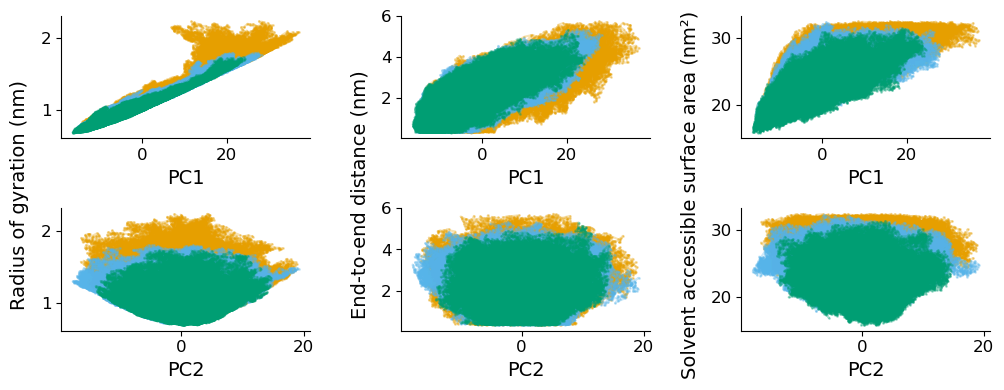

In [119]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,4))

for i in range(3):
    # Radius of gyration
    rg = np.load('{}/Data/Rg_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    axes[0,0].plot(reduced_distances[:,0][i*Nframes:(i+1)*Nframes], rg, marker='o', linestyle=None, markersize=1, alpha=0.3)
    axes[1,0].plot(reduced_distances[:,1][i*Nframes:(i+1)*Nframes], rg, marker='o', linestyle=None, markersize=1, alpha=0.3)
    
    # End-to-end distance
    end_to_end_distances = np.load('{}/Data/end-to-end_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    axes[0,1].plot(reduced_distances[:,0][i*Nframes:(i+1)*Nframes], end_to_end_distances, marker='o', linestyle=None, markersize=1, alpha=0.3)
    axes[1,1].plot(reduced_distances[:,1][i*Nframes:(i+1)*Nframes], end_to_end_distances, marker='o', linestyle=None, markersize=1, alpha=0.3)
    
    # Solvent accessible surface area (SASA)
    SASAs = np.load('{}/Data/SASA_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    axes[0,2].plot(reduced_distances[:,0][i*Nframes:(i+1)*Nframes], SASAs, marker='o', linestyle=None, markersize=1, alpha=0.3)
    axes[1,2].plot(reduced_distances[:,1][i*Nframes:(i+1)*Nframes], SASAs, marker='o', linestyle=None, markersize=1, alpha=0.3)
    
    # Labels
    axes[0,i].set_xlabel('PC1',fontsize=14)
    axes[1,i].set_xlabel('PC2',fontsize=14)

for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.text(-0.0, 0.5, 'Radius of gyration (nm)', fontsize=14, va='center', rotation='vertical')
fig.text(0.34, 0.5, 'End-to-end distance (nm)', fontsize=14, va='center', rotation='vertical')
fig.text(0.67, 0.5, 'Solvent accessible surface area (nm²)', fontsize=14, va='center', rotation='vertical')

fig.tight_layout(w_pad=4)
fig.savefig('Figures/PC_polymer_properties_correlation.pdf', bbox_inches='tight')

### Binding of Na<sup>+</sup> to PEG as a function of concentration

In [ ]:
%cd -q $homedir
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
subax = fig.add_axes([0.5, 0.3, 0.47, 0.5])
num_cores = 64  # Replace with your desired number of cores

# Physical constants
Na = 6.02214076*1e23 # [1/mol]
nm3_to_l = 1e-24

def process_residue(residue):
    pairs = traj.topology.select_pairs(selection1="(resname =~ 'PG*') and (element == O)",
                                       selection2="index {}".format(residue))
    distances = md.compute_distances(traj, pairs, periodic=True, opt=True)
    return np.sum(distances < 0.3, axis=1) > 3

def Langmuir_adsorption(concentration, Keq, max):
    return (max*concentration)/(Keq+concentration)

avg_bound = [0]
sampled_concentrations = [0]

i = 0
for conc,traj in zip(list(salt_concentrations.keys())[1:],trajs[1:]):
    conc = '{0:.2f}'.format(float(conc))
    
    # Generate array to store number of Na+ coordinations over the trajectory
    data = np.ones(shape=(len(traj.topology.select('element == Na')), traj.n_frames))
    
    with Pool(num_cores) as pool:
        results = pool.map(process_residue, traj.topology.select('element == Na'))
    
    # Update data array with results
    data[:len(results)] = np.array(results)
    
    # Sum up all the sodium bound in the individual frames
    bound_ions = data.sum(axis=0)

    if conc in ['0.25', '1.00', '5.00']:
        # Plot Histogram
        z, edges = np.histogram(bound_ions, bins=np.arange(0,8), density=True)
        edges = edges - 0.3 + 0.3*i
        subax.bar(edges[:-1], z, width=0.3, label=conc+' M')
        i+=1
        
    # Calculate the average over the whole trajectory
    avg_bound.append(bound_ions.mean())

    # Calculate the sampled NaCl concentration
    f = open('Simulations/PEG36mer/NaCl/{}/Solute/packmol.in'.format(conc))
    lines = f.readlines()
    f.close()
    Nsalt = float(re.findall(r'\b\d+\b',lines[14])[0])
    volume = np.loadtxt('Simulations/PEG36mer/NaCl/5.00/Solute/output.dat', usecols=(4), unpack=True)
    sampled_concentrations.append(Nsalt / (volume.mean() * Na * nm3_to_l))
    
    print('{} Done'.format(conc))

# Plot data
ax.plot(sampled_concentrations, avg_bound, 'o', color='black')

# Conduct fitting and plot 
popt, pcov = curve_fit(Langmuir_adsorption, sampled_concentrations, avg_bound)
perr = np.sqrt(np.diag(pcov))

print('\n==Fitting Results==')
for parm in zip(['Keq','Bmax'], popt, perr):
    print('{}:\t{:.2f}±{:.2f}'.format(*parm))

ax.plot(np.arange(0, 20, 0.1), Langmuir_adsorption(np.arange(0, 20, 0.1), *popt), '--', color='black')
ax.set_xlabel('NaCl concentration (M)', fontsize=14)
ax.set_ylabel('Average number of Na⁺ bound', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

subax.set_xlabel('Number of Na⁺ bound')
subax.set_ylabel('Probability mass')
subax.spines['right'].set_visible(False)
subax.spines['top'].set_visible(False)
subax.legend(loc='upper right', frameon=False)
subax.set_xticks(range(0,7))

fig.tight_layout()
fig.savefig('Figures/PEG36_Na_adsorption.pdf', bbox_inches='tight')

## Solvation Free Energy Analysis
### Defining our BAR solvation free energy functions

In [120]:
def BAR_solvation_free_energy(D, state_A, state_B, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    # Asign two states
    dSLVFE_AB = state_A[1] - state_A[0]
    dSLVFE_BA = -(state_B[1] - state_B[0])
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

def BAR_error_solvation_free_energy(D, state_A, state_B, state_A_errs, state_B_errs, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    def F(x): # Fermi-Dirac function
        return 1/(1+np.exp(x))
    def FF(x): # Eq. 21
        return -RT*F(x)*F(-x)
    
    # Asign two states (Propagation of errors)
    dSLVFE_AB = unumpy.uarray(state_A[1], state_A_errs[1]) - unumpy.uarray(state_A[0], state_A_errs[0])
    dSLVFE_BA = -(unumpy.uarray(state_B[1], state_B_errs[1]) - unumpy.uarray(state_B[0], state_B_errs[0]))
    
    # Calculate the denominator of Eq. 20
    nominators = []
    denominator = 0
    for slvfe in [*unumpy.nominal_values(dSLVFE_AB), *unumpy.nominal_values(dSLVFE_BA)]:
        value = FF(D-slvfe)
        denominator += value
        nominators.append(value)
        
    # Summuation of the error (Eq. 19)
    BAR_error = 0
    for C, slvfe_err in zip(nominators, [*unumpy.std_devs(dSLVFE_AB), *unumpy.std_devs(dSLVFE_BA)]):
        BAR_error+= (C/denominator)**2 * slvfe_err**2
    return float(np.sqrt(BAR_error))

### Loading Solvation Free Energies

In [121]:
%cd -q $homedir

# Load the NaCl results from the disk
slvfe       = np.load('Data/slvfe_PEG_NaCl.npy')
slvfe_err   = np.load('Data/slvfe_err_PEG_NaCl.npy')
mesh_err    = np.load('Data/mesh_err_PEG_NaCl.npy')
self_energy = np.load('Data/self_err_PEG_NaCl.npy')

# choose max errors for slefe
max_err = np.maximum.reduce([slvfe_err,mesh_err,self_energy])

### Solvation free energy as a function of concentration given different reference states

[None, None]

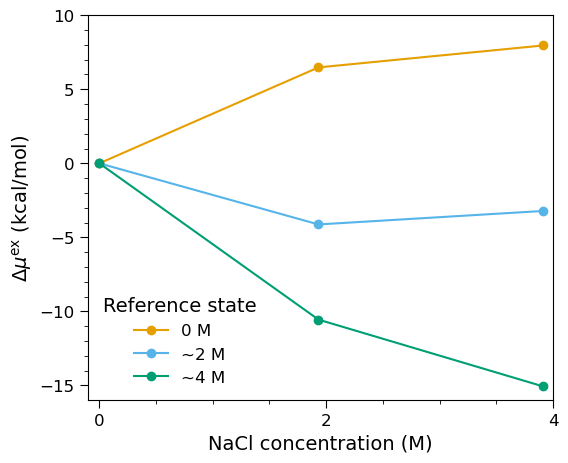

In [122]:
%cd -q $homedir

# Start with a Figure
fig, ax = plt.subplots(figsize=(6, 5))

# Obtain the sampled concentrations
sampled_concentrations = []
for conc in [0.0, 2.0, 4.0]:
    # Calculate the sampled NaCl concentration
    f = open('Simulations/PEG36mer/NaCl/{:.2f}/Solute/packmol.in'.format(conc))
    lines = f.readlines()
    f.close()
    Nsalt = float(re.findall(r'\b\d+\b',lines[14])[0])
    volume = np.loadtxt('Simulations/PEG36mer/NaCl/{:.2f}/Solute/output.dat'.format(conc), usecols=(4), unpack=True)
    sampled_concentrations.append(Nsalt / (volume.mean() * Na * nm3_to_l))

# Plot the data
labels = ['0 M', '~2 M', '~4 M']
for i, (data, err) in enumerate(zip(slvfe, max_err)):
    y = unumpy.uarray(data, err).mean(axis=1)
    y-=y[0]
    # If errors are non-neglectable use errorbar plot instead
    #ax.errorbar(sampled_concentrations, unumpy.nominal_values(y), yerr=unumpy.std_devs(y))
    ax.plot(sampled_concentrations, unumpy.nominal_values(y), marker='o', markersize=6, label=labels[i])
    
    
# Beautificaiton
ax.set_ylabel('$\Delta \mu^{\mathrm{ex}}$ (kcal/mol)', fontsize=14)
ax.set_xlabel('NaCl concentration (M)', fontsize=14)

xtick_major = [0, 2, 4]
xtick_minor = [0.5, 1, 1.5, 2.5, 3, 3.5]

ax.set_ylim(-16, 10)
ax.set_xlim(-0.1, 4)
ax.minorticks_on()
ax.set_xticks(ticks=xtick_major, minor=False)
ax.set_xticks(ticks=xtick_minor, minor=True)
ax.tick_params(axis='both', which='major', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, length=3)

legend = ax.legend(loc='best', title='Reference state', frameon=False, fontsize=12)
plt.setp(legend.get_title(),fontsize='14')

#fig.savefig('Figures/slvfe_concentration.pdf', bbox_inches='tight')
#fig.savefig('Figures/slvfe_concentration.png', bbox_inches='tight', dpi=600)

### Solvation free energy as a function of concentration as dictated by the inequality

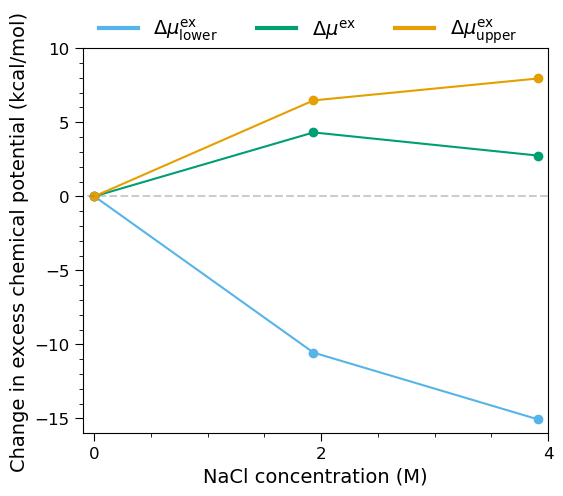

In [230]:
%cd -q $homedir

RT = 0.001987 * 298.15

# Start with a Figure
fig, ax = plt.subplots(figsize=(6, 5))

# Plot the data: LOWER
y = unumpy.uarray(slvfe[2], max_err[2])
y = (y-y[0]).mean(axis=1)
ax.plot(sampled_concentrations, unumpy.nominal_values(y), marker='o', markersize=6, color='C1')

# Plot the data: BAR
bar     = np.zeros(shape=len(salt_reference_concentrations))
bar_err = np.zeros(shape=len(salt_reference_concentrations))

i = 0 # Take everything relative to water
for j in range(slvfe.shape[1]):
    a = np.stack((slvfe[i,i], slvfe[i,j]), axis=0)
    b = np.stack((slvfe[j,j], slvfe[j,i]), axis=0)
    a_err = np.stack((max_err[i,i], max_err[i,j]), axis=0)
    b_err = np.stack((max_err[j,j], max_err[j,i]), axis=0)
    initial_guess = ((slvfe[i,j].mean()-slvfe[i,i].mean())+
                     (slvfe[j,j].mean()-slvfe[j,i].mean()))/2
    result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                               args=(a,b,298.15))
    bar[j] = result.x[0]*RT
    bar_err[j] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err)

ax.plot(sampled_concentrations, bar, marker='o', markersize=6, color='C2')


# Plot the data: UPPER
y = unumpy.uarray(slvfe[0], max_err[0])
y = (y-y[0]).mean(axis=1)
ax.plot(sampled_concentrations, unumpy.nominal_values(y), marker='o', markersize=6, color='C0')


# Beautification
ax.hlines(0, -1, 4, color='gray', alpha=0.4, linestyle='dashed')
ax.set_ylabel('Change in excess chemical potential (kcal/mol)', fontsize=14)
ax.set_xlabel('NaCl concentration (M)', fontsize=14)

xtick_major = [0, 2, 4]
xtick_minor = [0.5, 1, 1.5, 2.5, 3, 3.5]

ax.set_ylim(-16, 10)
ax.set_xlim(-0.1, 4)
ax.minorticks_on()
ax.set_xticks(ticks=xtick_major, minor=False)
ax.set_xticks(ticks=xtick_minor, minor=True)
ax.tick_params(axis='both', which='major', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, length=3)

lower_patch = Line2D([], [], color='C1', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2', lw=3, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch], loc='lower center', ncol=3, fontsize=14,
           bbox_to_anchor=(0.5, 0.85), frameon=False)

### Solvent decomposition of the solvation

In [168]:
%cd -q $homedir

solvent_contributions = np.zeros(shape=(len(salt_reference_concentrations), len(salt_reference_concentrations),
                                        NConfs, 4))

solvent_contributions_err = np.zeros(shape=(len(salt_reference_concentrations), len(salt_reference_concentrations),
                                            NConfs, 4))

for i, (conc_ensemble, perturb1) in enumerate(salt_reference_concentrations.items()):
    conc_ensemble = '{0:.2f}'.format(conc_ensemble)
    for j, (conc_perturbation, perturb2) in enumerate(salt_reference_concentrations.items()):
        conc_perturbation = '{0:.2f}'.format(conc_perturbation)
        P = str(*[k for k, v in perturb1.items() if v==perturb2['P0']])

        for conf in range(NConfs):
            path = 'Simulations/PEG36mer/NaCl/{conc}/{P}/{conf}/'.format(conc=conc_ensemble, P=P, conf=conf)
            with open(path+'ermod.out','r') as f:
                lines = f.readlines()
            f.close()
            
            for lineNR, line in enumerate(lines):
                if "cumulative average & 95% error for solvation free energy" in line:
                    if perturb1[P] == 0:
                        solvent_contributions[i,j,conf,0] = float(lines[lineNR+50+0].split()[1])
                        solvent_contributions[i,j,conf,3] = float(lines[lineNR+50+0].split()[1])
                        solvent_contributions_err[i,j,conf,0] = float(lines[lineNR+50+0].split()[2])
                        solvent_contributions_err[i,j,conf,3] = float(lines[lineNR+50+0].split()[2])
                    else:
                        solvent_contributions[i,j,conf,:] = np.array(lines[lineNR+50+1].split()[1::2]).astype(float)
                        solvent_contributions_err[i,j,conf,:] = np.array(lines[lineNR+50+1].split()[2::2]).astype(float)

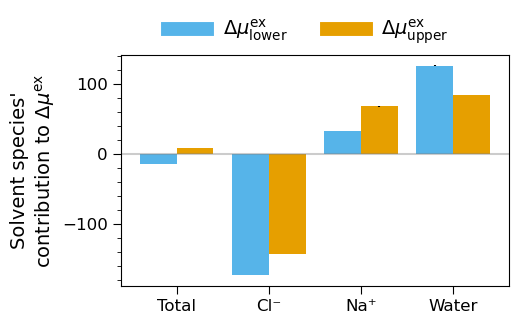

In [220]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

data = unumpy.uarray(solvent_contributions, solvent_contributions_err)
meaned_data = data.mean(axis=2)

# Plotting
width=0.4
## Lower limit
bar_data = meaned_data[2,2] - meaned_data[2,0]
ax.bar(x=np.arange(0,4)-width/2, height=unumpy.nominal_values(bar_data),
       width=width, yerr=unumpy.std_devs(bar_data), color='C1')

## Upper limit
bar_data = meaned_data[0,2] - meaned_data[0,0]
ax.bar(x=np.arange(0,4)+width/2, height=unumpy.nominal_values(bar_data),
       width=width, yerr=unumpy.std_devs(bar_data), color='C0')

# Beautification
ax.set_ylabel("Solvent species'\ncontribution to $\Delta\mu^{\mathrm{ex}}$", fontsize=14)
ax.set_xticks([0, 1, 2, 3], labels=['Total', 'Cl⁻', 'Na⁺', 'Water'], fontsize=14)

ax.hlines(0, -2, 5, color='gray', alpha=0.4)
ax.set_xlim(-0.6, 3.6)
ax.minorticks_on()
ax.set_xticks(ticks=[], minor=True)
ax.tick_params(axis='both', which='major', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, length=3)

lower_patch = Line2D([], [], color='C1', lw=10, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
upper_patch = Line2D([], [], color='C0', lw=10, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')

fig.legend(handles=[lower_patch, upper_patch], loc='lower center', ncol=3, fontsize=14,
           bbox_to_anchor=(0.5, 0.85), frameon=False)